In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

/home/j26483/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/j26483/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (
/tmp/ipykernel_15879/4004275526.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No Bottleneck unit testing available.


In [2]:
pywake_no_blockage = xr.load_dataset('pyWake/pywake_linear_bast.nc')
pywake_blockage = xr.load_dataset('pyWake/pywake_FUGA.nc')

In [3]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
foxes_pred = [xr.load_dataset('foxes/turbine_data_validation_inputs_foxes_%s.nc' % letters[ii]) for ii in range(len(letters))]

In [4]:
wayve_dat = pd.read_csv('WAYVE/power_windio_les_validation_wayve.csv')

In [5]:
code_saturne_dat = pd.read_csv('code_saturne/power_validation_code_saturne.csv')
code_saturne_rho = pd.read_csv('code_saturne/Density_validation_code_saturne.csv')
##uncomment to try density correction
rho_to_use = 1.225
code_saturne_dat.values[:,1:] = rho_to_use*code_saturne_dat.values[:,1:]/code_saturne_rho.values[:,1:]

In [6]:
np.array([wayve_dat.iloc[0].values[1:].max(), code_saturne_dat.iloc[0].values[1:].max(), 1e3 * foxes_pred[0].isel(state=0).P.values.max(),  pywake_no_blockage.isel(time=0).Power.values.max()]) / 1e6

array([9.19739901, 8.45817749, 9.56214647, 9.56215049])

In [7]:
les_dat = pd.read_csv('LES/power_windio_les_validation.csv')

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of cases
num_cases = 27

# Initialize lists for storing metrics
mse_values = {letter: [] for letter in letters}
mse_values['PyWake Blockage'] = []
mse_values['PyWake No Blockage'] = []
mse_values['WAYVE'] = []
mse_values['Code_Saturne'] = []

# Common grid for CDF
common_grid = np.linspace(0, 1.3e7, 1000)  # Example range, adjust as needed

# Calculating MSE and area between CDFs for each case
for case_num in range(num_cases):
    les_case_values = les_dat.iloc[case_num].values[1:]

    # FOXES models
    for ll, letter in enumerate(letters):
        foxes_values = foxes_pred[ll].isel(state=case_num).P.values * 1e3
        mse = np.sqrt(np.mean((foxes_values - les_case_values) ** 2)) / 1e6
        mse_values[letter].append(mse)

    # PyWake Blockage
    pywake_blockage_values = pywake_blockage.isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake Blockage'].append(mse)

    # PyWake No Blockage
    pywake_no_blockage_values = pywake_no_blockage.isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_no_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake No Blockage'].append(mse)

    # Code_Saturne
    saturne_values = code_saturne_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((saturne_values - les_case_values) ** 2)) / 1e6
    mse_values['Code_Saturne'].append(mse)
    
    # WAYVE
    wayve_values = wayve_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((wayve_values - les_case_values) ** 2)) / 1e6
    mse_values['WAYVE'].append(mse)

In [9]:
#From Lanzilau et al 2023 TABLE 1
dtheta_values = [1.95, 2.19, 2.49, 4.93, 5.15, 5.42, 7.93, 8.15, 8.46, \
         2.04, 2.26, 2.54, 5.05, 5.28, 5.59, 8.05, 8.29, 8.61, \
         2.08, 2.32, 2.65, 5.08, 5.33, 5.33, 8.08, 8.33, 8.67]
gamma_values = 9*[0.004, 0.008, 0.001]
hlim_values_ini = 9*[300.] + 9*[500] + 9*[1000]

#Info sent by Koen
hlim_values = [381.084457, 378.5305963, 375.4294404, 360.8665826, 360.2301865, 359.5488626, 355.7189003, 355.567335, 355.3268325, 560.7548830999999, 559.4752178, 558.1046807, 553.0758510000001, 552.9558681999999, 552.7154538, 551.5397495, 551.729999, 551.6794682, 1051.2415718, 1051.0760946999999, 1050.9615334, 1050.4818971, 1050.5696495, 1050.5281456, 1050.3608803, 1050.407467, 1050.4057154]
fp_values = [16.86284927398932, 24.216641476883694, 29.382307236439992, 62.19382970657945, 56.16954130731057, 52.731935466419635, 184.99507438914455, 100.75027869691722, 78.23668229173681, 19.57725011141846, 23.680800005753955, 25.623258391714298, 80.8944154674684, 47.683608598445346, 39.46276896858717, 63.124626616163, 50.108157046171144, 43.06711591758399, 20.30167002242763, 16.583502589574028, 15.774192135448086, 25.61692843684896, 20.41033193124303, 18.228139016526878, 20.41358231834358, 19.00900665518914, 17.940814981243385] #blockage

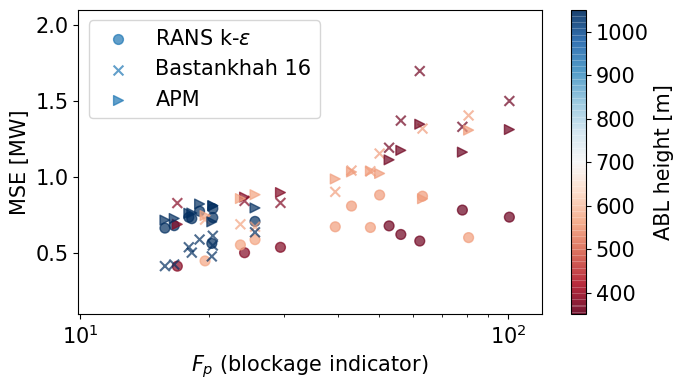

                 RANS         Bastankhah          APM
Mean MSE : 0.6671347633077969 0.9308554220620837 0.9617838445482334
Std of MSE : 0.11723126907723283 0.39554777725338125 0.23968947804104074


In [10]:
#
fig,ax = plt.subplots(1,1,figsize=(7,4)) 
color_values=hlim_values ; color_label = "ABL height [m]"; vmin=350; vmax=1050
cb=plt.scatter(fp_values, mse_values['Code_Saturne'], label="RANS k-$\epsilon$", s=50, \
               marker="o",alpha=0.7, c=color_values, vmin=vmin,vmax=vmax, cmap=plt.cm.RdBu)
plt.scatter(fp_values, mse_values['F'], label="Bastankhah 16",  s=50,\
            marker="x",alpha=0.7, c=color_values, vmin=vmin,vmax=vmax, cmap=plt.cm.RdBu)
plt.scatter(fp_values, mse_values['WAYVE'], label="APM",  s=50,\
            marker=">",alpha=0.7, c=color_values, vmin=vmin,vmax=vmax, cmap=plt.cm.RdBu)
cb1 = plt.colorbar(cb, label=color_label)
plt.xlabel(r'$F_p$ (blockage indicator)')
plt.xscale('log')
plt.ylim(0.1,2.1)
plt.ylabel('MSE [MW]')
#plt.xlim(1,9)
plt.xlim(9.9,120)
#plt.tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
plt.legend(loc="upper left", ncol=1, prop={"size":15})

#
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
cb1.ax.yaxis.label.set_size(15)
cb1.ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig("validation_error_scatter")
plt.show()

print('                 RANS         Bastankhah          APM')
print('Mean MSE :', np.mean(mse_values['Code_Saturne']), np.mean(mse_values['F']), np.mean(mse_values['WAYVE']))
print('Std of MSE :',np.std(mse_values['Code_Saturne']), np.std(mse_values['F']), np.std(mse_values['WAYVE']))

In [11]:
case_num=2
turbine_info_table = np.genfromtxt("turbines_info.csv", skip_header=1, delimiter=',')
turbine_diameter=198
x_coords = (turbine_info_table[:,0]-turbine_info_table[0,0])/turbine_diameter
y_coords = turbine_info_table[:,1]

power_tables = [les_dat.iloc[case_num].values[1:],  wayve_dat.iloc[case_num].values[1:], \
               code_saturne_dat.iloc[case_num].values[1:], foxes_pred[5].isel(state=case_num).P * 1e3, \
               pywake_no_blockage.isel(time=case_num).Power, pywake_blockage.isel(time=case_num).Power]
power_titles = ["LES", "Wayves", "code_saturne", "Foxes "+letters[5], "Pywake", "Pywake Blockage"]

#plt.figure(figsize=(9, 6))
fig, ax = plt.subplots(2, 3,figsize=(20,10))
for j in range(6):
    plt.subplot(2, 3, j+1)
    cntr = plt.scatter(x=x_coords, y=y_coords, c=power_tables[j]/1e6,
                    cmap=plt.cm.get_cmap('jet'), s=80, vmin=2, vmax =11, edgecolors='k') #bwr
    plt.xlim(1.2*np.min(x_coords), 1.2*np.max(x_coords))
    plt.ylim(1.2*np.min(y_coords), 1.2*np.max(y_coords))
    plt.title(power_titles[j])
    if(j==5):
        plt.colorbar(cntr, ax=ax, fraction=0.03, pad=0.01, label=r'$P [MW]$')
    plt.xlabel(u'$x/D$')
    plt.ylabel(u'$y$ $(m)$')
    plt.xlim(-10,85)
    #plt.tight_layout()
plt.show()

FileNotFoundError: turbines_info.csv not found.

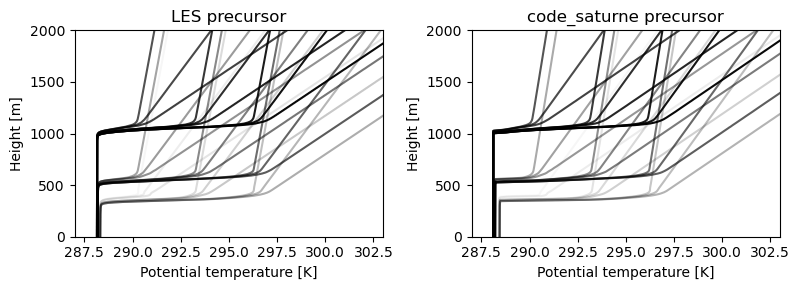

In [12]:
import netCDF4 as nc
LES_precursor = nc.Dataset("../validation_inputs/plant_energy_resource/full_validation_dataset.nc")
LES_z = LES_precursor.variables["z"][:]
LES_pot_temp = LES_precursor.variables["pot_temp"][:,:]
LES_speed = LES_precursor.variables["speed"][:,:]
LES_dir = LES_precursor.variables["direction"][:,:]
#
code_saturne_precursor = nc.Dataset("code_saturne/precursor_meteo_code_saturne.nc")
code_saturne_z = code_saturne_precursor.variables["z"][:]
code_saturne_pot_temp = code_saturne_precursor.variables["pot_temp"][:,:]
code_saturne_speed = code_saturne_precursor.variables["speed"][:,:]
code_saturne_dir = code_saturne_precursor.variables["direction"][:,:]

# Plotting the results
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
for j in range(27):
    plt.plot(LES_pot_temp[j,:], LES_z, color="k", alpha=(j+1)/28)
plt.xlabel('Potential temperature [K]')
plt.ylabel('Height [m]')
plt.title("LES precursor")
plt.tight_layout()
plt.ylim(0.,2000)
plt.xlim(287,303)

plt.subplot(1, 2, 2)
for j in range(27):
    plt.plot(code_saturne_pot_temp[j,:], code_saturne_z, color="k", alpha=j/27)
plt.xlabel('Potential temperature [K]')
plt.ylabel('Height [m]')
plt.title("code_saturne precursor")
plt.tight_layout()
plt.ylim(0.,2000)
plt.xlim(287,303)
#
plt.show()

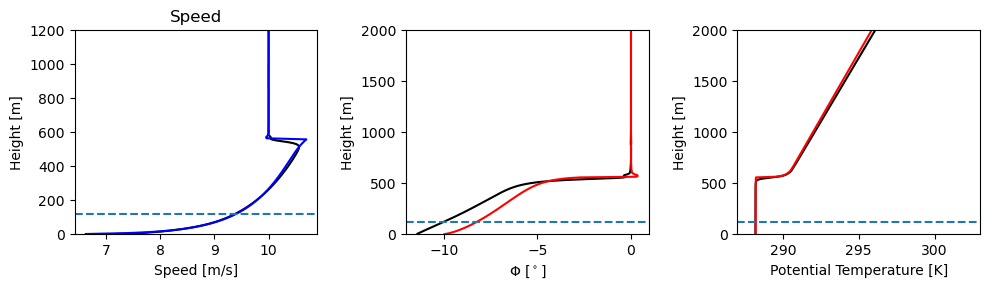

In [13]:
j=10

# Plotting the results
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)

plt.plot(LES_speed[j,:], LES_z, color="k", label="LES")
plt.plot(code_saturne_speed[j,:], code_saturne_z, color="b", label="code_saturne")
plt.xlabel('Speed [m/s]')
plt.ylabel('Height [m]')
plt.title("Speed")
plt.tight_layout()
plt.axhline(119, linestyle="--")
plt.ylim(0.,1200)
#plt.xlim(9,11)
#
plt.subplot(1, 3, 2)
plt.plot(LES_dir[j,:]-LES_dir[j,-1], LES_z, color="k", label="LES")
plt.plot(code_saturne_dir[j,:]-code_saturne_dir[j,-1], code_saturne_z, color="r", label="code_saturne")
plt.xlabel('$\Phi$ [$^\circ$]')
plt.ylabel('Height [m]')
plt.axhline(119, linestyle="--")
plt.tight_layout()
plt.ylim(0.,2000)
#plt.xlim(9,11)
#
#
plt.subplot(1, 3, 3)
plt.plot(LES_pot_temp[j,:], LES_z, color="k", label="LES")
plt.plot(code_saturne_pot_temp[j,:], code_saturne_z, color="r", label="code_saturne")
plt.xlabel('Potential Temperature [K]')
plt.ylabel('Height [m]')
plt.axhline(119, linestyle="--")
plt.tight_layout()
plt.ylim(0.,2000)
plt.xlim(287,303)
plt.show()

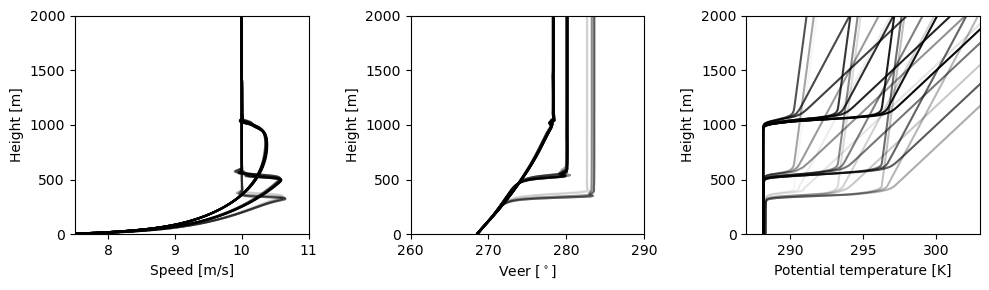

In [31]:
# Plotting the results
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
for j in range(27):
    plt.plot(LES_speed[j,:], LES_z, color="k", alpha=(j+1)/28)
plt.xlabel('Speed [m/s]')
plt.ylabel('Height [m]')
plt.tight_layout()
#plt.axhline(119, linestyle="--")
plt.ylim(0.,2000)
plt.xlim(7.5,11)
#
plt.subplot(1, 3, 2)
for j in range(27):
    plt.plot(LES_dir[j,:], LES_z, color="k", alpha=(j+1)/28)
plt.xlabel('Veer [$^\circ$]')
plt.ylabel('Height [m]')
#plt.axhline(119, linestyle="--")
plt.tight_layout()
plt.ylim(0.,2000)
plt.xlim(260,290)

plt.subplot(1, 3, 3)
for j in range(27):
    plt.plot(LES_pot_temp[j,:], LES_z, color="k", alpha=(j+1)/28)
plt.xlabel('Potential temperature [K]')
plt.ylabel('Height [m]')

plt.tight_layout()
plt.ylim(0.,2000)
plt.xlim(287,303)

plt.savefig("validation_data.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
for j in range(27):
    plt.plot(LES_speed[j,:], LES_z, color="k", alpha=j/27)
plt.xlabel('Speed [m/s]')
plt.ylabel('Height [m]')
plt.tight_layout()
plt.axhline(119, linestyle="--")
plt.ylim(0.,2000)
plt.xlim(9,11)

plt.subplot(1, 2, 2)
for j in range(27):
    plt.plot(code_saturne_speed[j,:], code_saturne_z, color="k", alpha=j/27)
plt.xlabel('Speed [m/s]')
plt.ylabel('Height [m]')
plt.title("code_saturne precursor")
plt.axhline(119, linestyle="--")
plt.tight_layout()
plt.ylim(0.,2000)
plt.xlim(9,11)
#
plt.show()

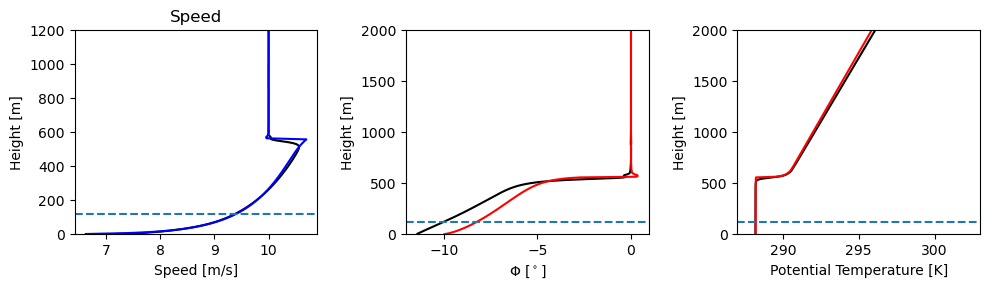

In [15]:
j=10

# Plotting the results
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)

plt.plot(LES_speed[j,:], LES_z, color="k", label="LES")
plt.plot(code_saturne_speed[j,:], code_saturne_z, color="b", label="code_saturne")
plt.xlabel('Speed [m/s]')
plt.ylabel('Height [m]')
plt.title("Speed")
plt.tight_layout()
plt.axhline(119, linestyle="--")
plt.ylim(0.,1200)
#plt.xlim(9,11)
#
plt.subplot(1, 3, 2)
plt.plot(LES_dir[j,:]-LES_dir[j,-1], LES_z, color="k", label="LES")
plt.plot(code_saturne_dir[j,:]-code_saturne_dir[j,-1], code_saturne_z, color="r", label="code_saturne")
plt.xlabel('$\Phi$ [$^\circ$]')
plt.ylabel('Height [m]')
plt.axhline(119, linestyle="--")
plt.tight_layout()
plt.ylim(0.,2000)
#plt.xlim(9,11)
#
#
plt.subplot(1, 3, 3)
plt.plot(LES_pot_temp[j,:], LES_z, color="k", label="LES")
plt.plot(code_saturne_pot_temp[j,:], code_saturne_z, color="r", label="code_saturne")
plt.xlabel('Potential Temperature [K]')
plt.ylabel('Height [m]')
plt.axhline(119, linestyle="--")
plt.tight_layout()
plt.ylim(0.,2000)
plt.xlim(287,303)
plt.show()

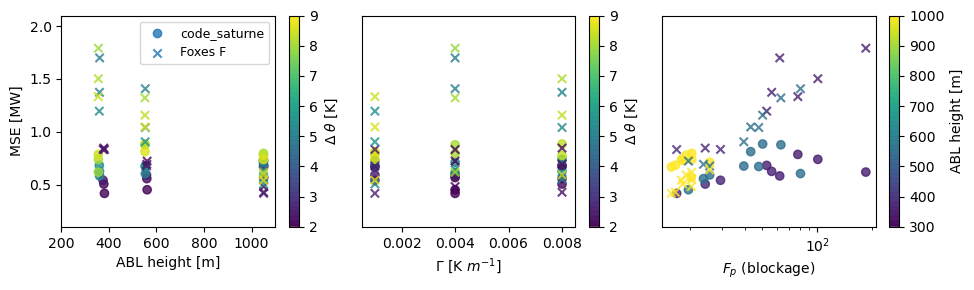

In [30]:
#Reminder of the keys : #"A", .., "G", "PyWake Blockage", "PyWake No Blockage", "WAYVE", "Code_Saturne"
# Plotting the results
plt.figure(figsize=(10, 3))
#
plt.subplot(1, 3, 1)
color_values=dtheta_values ; color_label = r"$\Delta$ $\theta$ [K]"; vmin=2; vmax=9
cb = plt.scatter(hlim_values, mse_values['Code_Saturne'], label="code_saturne", \
                 marker="o",alpha=0.8, c=color_values,  vmin=vmin,vmax=vmax)
plt.scatter(hlim_values, mse_values['F'], label="Foxes F", \
            marker="x",alpha=0.8, c=color_values, vmin=vmin,vmax=vmax)
plt.colorbar(cb, label=color_label)
plt.xlabel('ABL height [m]')
plt.ylabel('MSE [MW]')
plt.ylim(0.1,2.1)
plt.xlim(200,1100)
plt.legend(loc="upper right", ncol=1, prop={"size":9})
#
plt.subplot(1, 3, 2)
color_values=dtheta_values ; color_label = r"$\Delta$ $\theta$ [K]"; vmin=2; vmax=9
cb=plt.scatter(gamma_values, mse_values['Code_Saturne'], label="code_saturne", \
               marker="o",alpha=0.8, c=color_values, vmin=vmin,vmax=vmax)
plt.scatter(gamma_values, mse_values['F'], label="Foxes F", \
            marker="x",alpha=0.8, c=color_values, vmin=vmin,vmax=vmax)
#
plt.colorbar(cb, label=color_label)
plt.xlabel('$\Gamma$ [K $m^{-1}$]')
plt.ylim(0.1,2.1)
plt.xlim(0.0005,0.0085)
plt.tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
#
plt.subplot(1, 3, 3)
color_values=hlim_values ; color_label = "ABL height [m]"; vmin=300; vmax=1000
cb=plt.scatter(fp_values, mse_values['Code_Saturne'], label="code_saturne", \
               marker="o",alpha=0.8, c=color_values, vmin=vmin,vmax=vmax)
plt.scatter(fp_values, mse_values['F'], label="Foxes F", \
            marker="x",alpha=0.8, c=color_values, vmin=vmin,vmax=vmax)
plt.colorbar(cb, label=color_label)
plt.xlabel(r'$F_p$ (blockage)')
plt.xscale('log')
plt.ylim(0.1,2.1)
#plt.xlim(1,9)
#plt.xlim(10e-1,10e2)
plt.tick_params(axis='y', which='both',left=False,right=False,labelleft=False)

#
plt.tight_layout()
plt.savefig("validation_error_scatter.pdf", dpi=300, bbox_inches='tight')
plt.show()